In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [20]:
np.random.seed(422)
SAMPLE_RATE = 16384 * 4

In [21]:
def cosinus_signal_func(freq = None, T = None, init_phase = 0):
    if freq:
        w = 2 * np.pi * freq
    elif T:
        w = 2 * np.pi / T
    else:
        return None
    cos_func = lambda t: np.cos(t * w + init_phase)

    return cos_func

def calc_signal(s_func, *args, t_start = 0, t_end = 2, samples = SAMPLE_RATE, noised=False):
    time_series = np.linspace(t_start, t_end, samples, endpoint=False)
    signal_vals = np.array([s_func(*args, t) for t in time_series])
    if noised: signal_vals += np.random.normal(0, 1, signal_vals.shape)

    return signal_vals, time_series

def get_positive_spectrum(signal, normalize=True, samplerate=SAMPLE_RATE):
    spectrum = np.fft.fft(signal)
    positive_spectrum = np.abs(spectrum[:len(spectrum) // 2])
    freq_resolution = samplerate / len(spectrum)
    positive_frequencies = np.arange(len(positive_spectrum)) * freq_resolution
    
    if normalize:
        positive_spectrum /= np.max(positive_spectrum)
    
    return positive_frequencies, positive_spectrum

In [22]:
def averaging_mean(signal, k):
    averaged_signal = []
    for i in range(k, len(signal)-k):
        s = np.sum(signal[i-k:i+k])
        averaged_signal.append(s * (2*k+1)**-1)
    return np.pad(averaged_signal, (k, k))

def averaging_gauss(signal, k, w):
    smoothed_signal = np.zeros(len(signal))
    t_values = np.arange(k, len(signal) - k)

    for t in t_values:
        i_values = np.arange(t - k, t + k) 
        weights = np.exp(-4 * np.log(2) * (i_values - t)**2 / w**2)
        total_weight = np.sum(weights)
        weighted_sum = np.sum(signal[i_values] * weights)
        smoothed_signal[t] = weighted_sum / total_weight

    return smoothed_signal

## Задание 1, 2

In [23]:
task_1_signal_f = lambda x: cosinus_signal_func(freq=10)(x) + cosinus_signal_func(freq=15)(x)

task1_sig_noised, cos_time_series = calc_signal(task_1_signal_f, t_end=1, noised=True)
task1_sig, cos_time_series = calc_signal(task_1_signal_f, t_end=1)
task1_sig_average = averaging_mean(task1_sig_noised, 100)
task2_sig_average = averaging_gauss(task1_sig_noised, 100, 20)

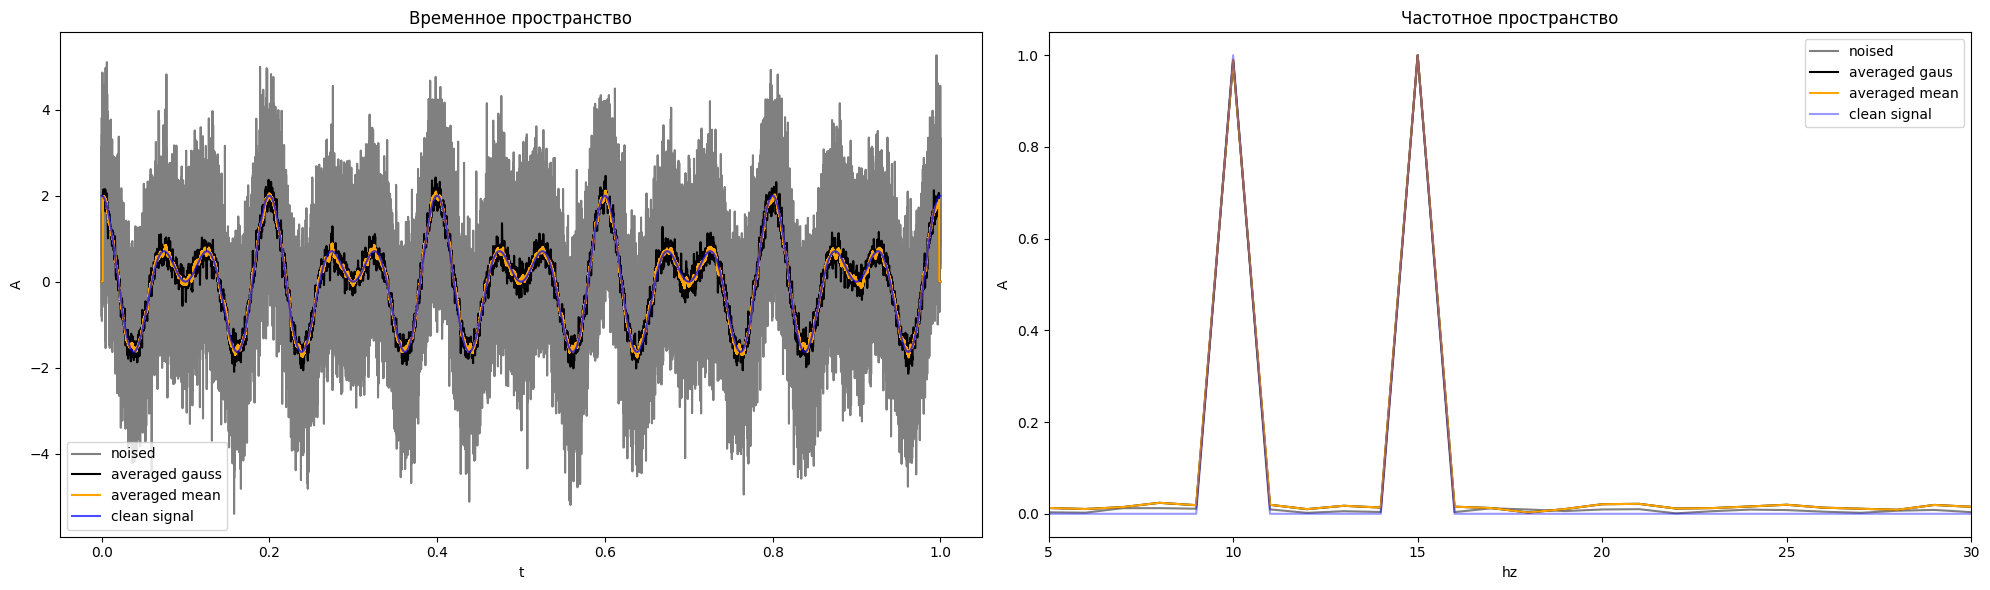

In [24]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.title("Временное пространство")
plt.plot(cos_time_series, task1_sig_noised, color='grey', label='noised')
plt.plot(cos_time_series, task2_sig_average, color='black', label='averaged gauss')
plt.plot(cos_time_series, task1_sig_average, color='orange', label='averaged mean')
plt.plot(cos_time_series, task1_sig, color='blue', alpha=0.7, label='clean signal')
plt.xlabel("t")
plt.ylabel("A")
plt.legend()

plt.subplot(122)
plt.title("Частотное пространство")
plt.xlabel("hz")
plt.ylabel("A")

plt.plot(*get_positive_spectrum(task1_sig_noised), color='grey', label='noised')
plt.plot(*get_positive_spectrum(task2_sig_average), color='black', label='averaged gaus')
plt.plot(*get_positive_spectrum(task1_sig_average), color='orange', label='averaged mean')
plt.plot(*get_positive_spectrum(task1_sig), color='blue', label='clean signal', alpha=0.4)
plt.xlim([5, 30])

plt.legend()
plt.tight_layout()
plt.show()

## Задание 3

In [25]:
def add_peaks(signal, p=0.2, peak=1):
    peaks = np.zeros_like(signal)
    if(peak != 1):
        peaks[:int(len(signal)*p)-1] = np.random.randint(0, peak, int(len(signal)*p)-1)
    else:
        peaks[:int(len(signal)*p)-1] = peak
    np.random.shuffle(peaks)
    return signal + peaks

In [26]:
task3_sig = scipy.signal.detrend(np.cumsum(np.random.randn(SAMPLE_RATE)))/100
task3_sig /= np.max(task3_sig)

task3_peaked = add_peaks(task3_sig, p=0.005)
task3_peaked_average = averaging_gauss(task3_peaked, 100, 20)

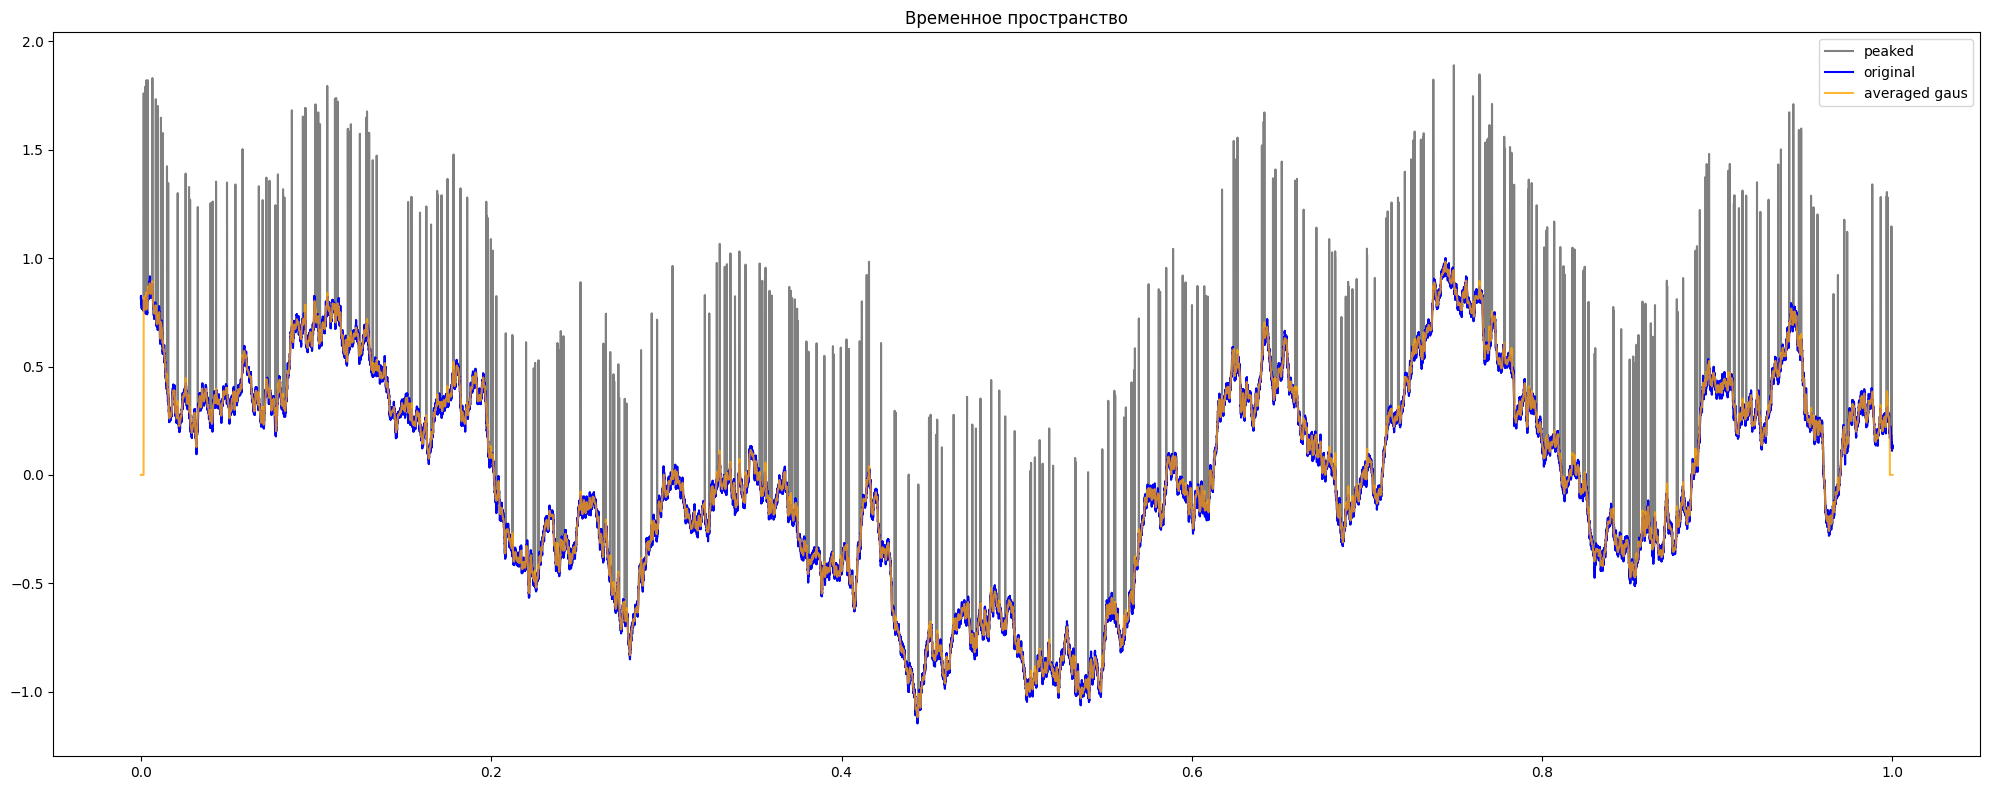

In [27]:
plt.figure(figsize=(20, 8))

plt.title("Временное пространство")
plt.plot(cos_time_series, task3_peaked, color='grey', label='peaked')
plt.plot(cos_time_series, task3_sig, color='blue', label='original')
plt.plot(cos_time_series, task3_peaked_average, color='orange', alpha=0.8, label='averaged gaus')

plt.legend()
plt.tight_layout()
plt.show()

## Задание 4

In [28]:
def meadin_filter(signal, k):
    filtered_signal = signal.copy()
    mean = np.mean(signal)
    mean_up_ids = np.where(signal>mean)
    for ind in mean_up_ids[0]:
        median = np.median(signal[ind-k:ind+k])
        filtered_signal[ind] = median
    return filtered_signal


In [29]:
task4_sig = scipy.signal.detrend(np.cumsum(np.random.randn(SAMPLE_RATE)))/100
task4_sig /= np.max(task3_sig)

task4_peaked = add_peaks(task4_sig, p=0.005, peak=25)
task4_peaked_average = meadin_filter(task4_peaked, 500)

d:\Programming\DigitalSignals\venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Programming\DigitalSignals\venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


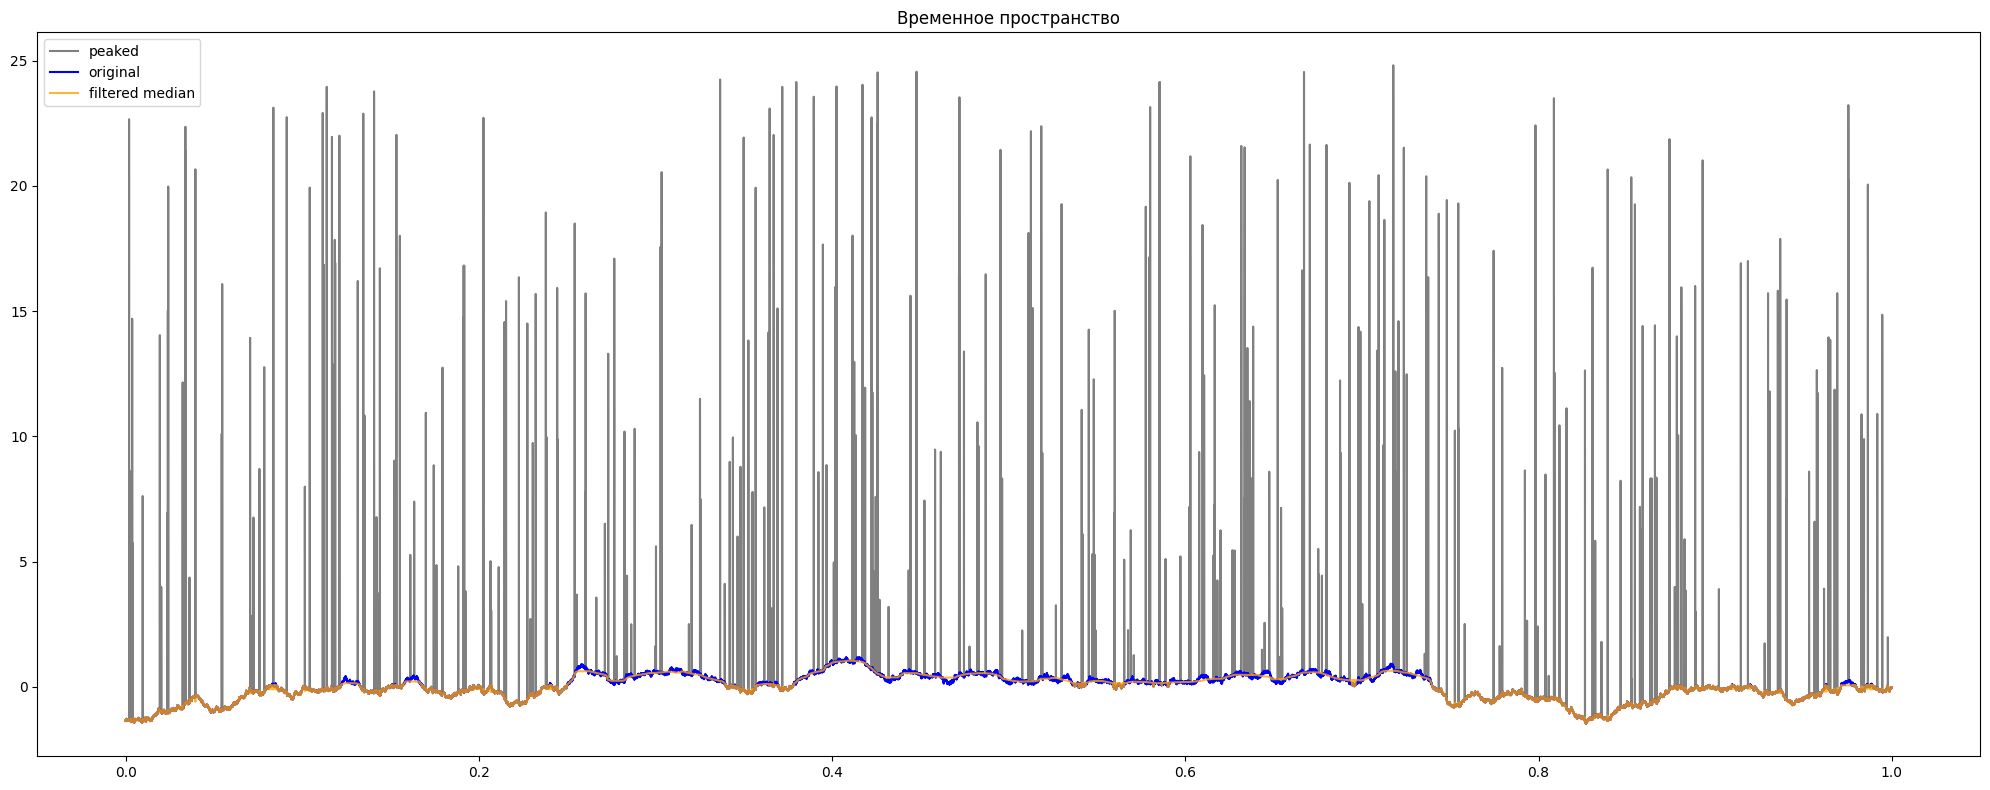

In [30]:
plt.figure(figsize=(20, 8))

plt.title("Временное пространство")
plt.plot(cos_time_series, task4_peaked, color='grey', label='peaked')
plt.plot(cos_time_series, task4_sig, color='blue', label='original')
plt.plot(cos_time_series, task4_peaked_average, color='orange', alpha=0.8, label='filtered median')

plt.legend()
plt.tight_layout()
plt.show()

## Задание 5

In [31]:
def spectral_interpolation(signal, gapped_indices_):
    gapped_indices = gapped_indices_[0]

    gapped_size = len(gapped_indices)
    window_size = gapped_size
    left_gapp_id = gapped_indices[0]
    right_gapp_id = gapped_indices[-1] + 1

    left_part = signal[left_gapp_id-window_size:left_gapp_id]
    right_part = signal[right_gapp_id:right_gapp_id+window_size]

    left_part_spectrum = np.fft.fft(left_part)
    right_part_spectrum = np.fft.fft(right_part)

    restored_part_spectrum = (left_part_spectrum + right_part_spectrum)/2

    restored_part = np.fft.ifft(restored_part_spectrum)

    restored_signal = signal.copy().astype(np.complex128)

    restored_signal[gapped_indices] = restored_part

    return restored_signal

In [32]:
GAP_LEFT_RATION = 0.5
GAP_RIGHT_RATION = 0.7

task5_timeseries = cos_time_series.copy()

np.random.seed(512)
task5_sig = scipy.signal.detrend(np.cumsum(np.random.randn(SAMPLE_RATE)))
task5_sig /= np.max(task5_sig)

task5_sig_gapped = task5_sig.copy()
task5_timeseries_gapped = task5_timeseries.copy()

task5_timeseries_gapped[(task5_timeseries>GAP_LEFT_RATION) & (task5_timeseries < GAP_RIGHT_RATION)] = np.NaN
task5_sig_gapped[(task5_timeseries>GAP_LEFT_RATION) & (task5_timeseries <GAP_RIGHT_RATION)] = np.NaN

restored_signal = spectral_interpolation(task5_sig_gapped, np.where((task5_timeseries>GAP_LEFT_RATION) & (task5_timeseries < GAP_RIGHT_RATION)))

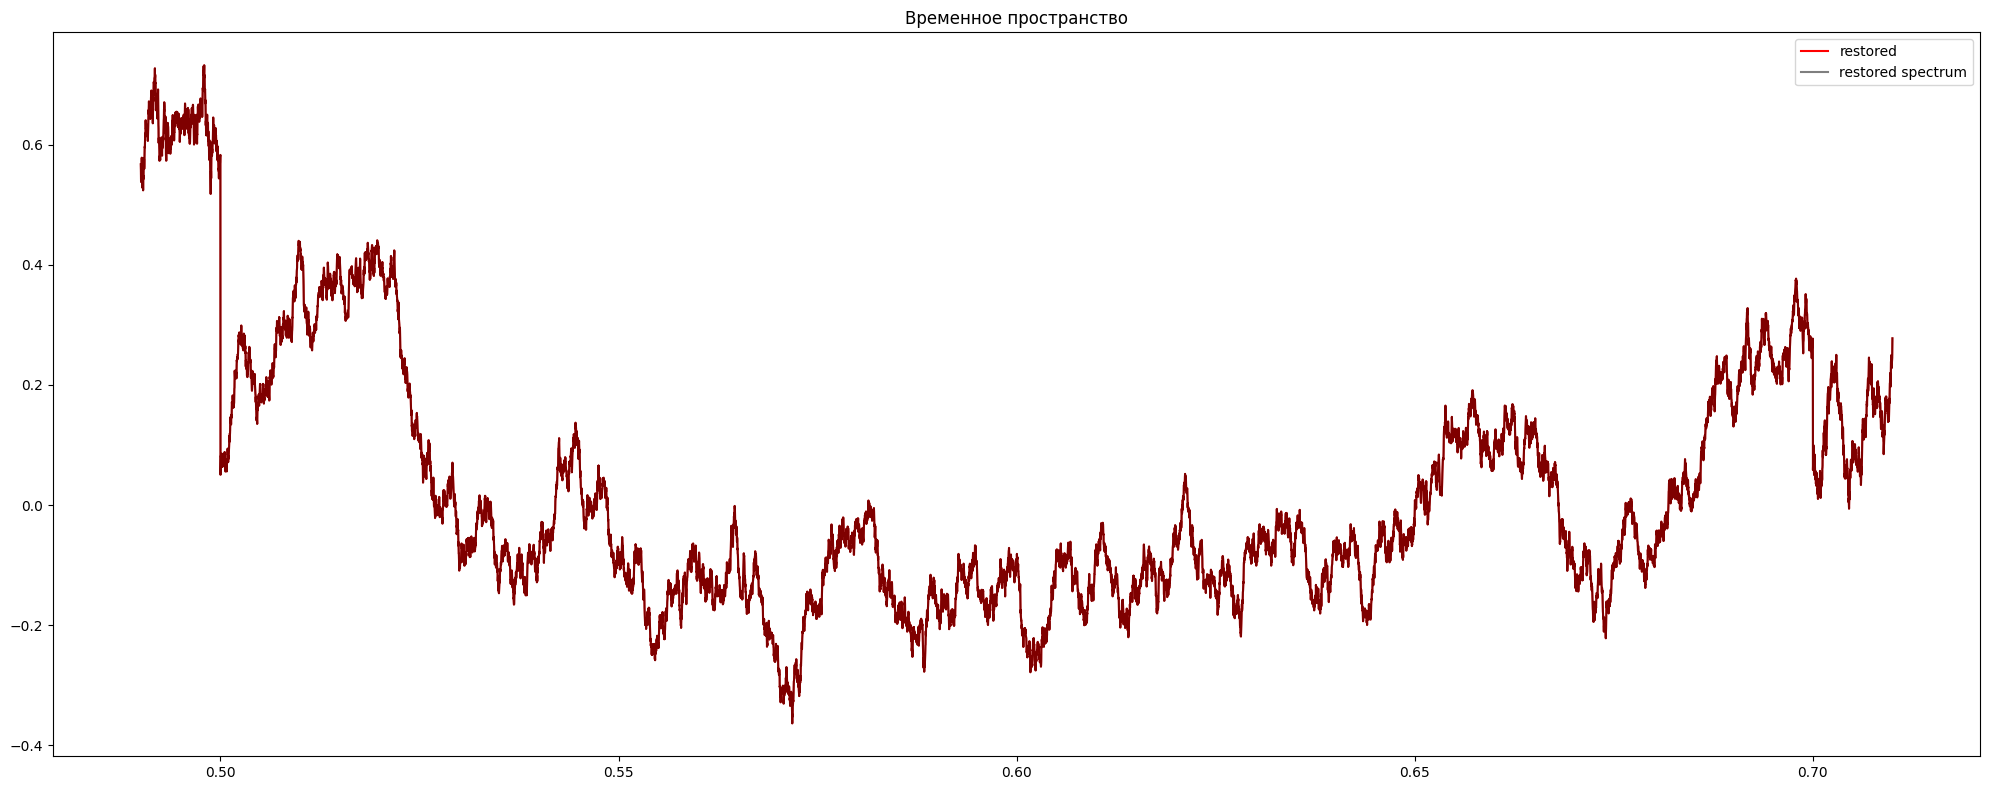

In [85]:
plt.figure(figsize=(20, 8))

plt.title("Временное пространство")
# plt.plot(task5_timeseries[(task5_timeseries>GAP_LEFT_RATION) & (task5_timeseries <GAP_RIGHT_RATION)], task5_sig[(task5_timeseries>GAP_LEFT_RATION) & (task5_timeseries < GAP_RIGHT_RATION)] , color='blue', label='original')
# plt.plot(task5_timeseries_gapped, task5_sig_gapped, color='grey', label='gapped')
plt.plot(task5_timeseries[(task5_timeseries>GAP_LEFT_RATION-0.01) & (task5_timeseries < GAP_RIGHT_RATION+0.01)], restored_signal[(task5_timeseries>GAP_LEFT_RATION-0.01) & (task5_timeseries < GAP_RIGHT_RATION+0.01)], color='red', label='restored')
plt.plot(task5_timeseries[(task5_timeseries>GAP_LEFT_RATION-0.01) & (task5_timeseries < GAP_RIGHT_RATION+0.01)], spect_interpol[(task5_timeseries>GAP_LEFT_RATION-0.01) & (task5_timeseries < GAP_RIGHT_RATION+0.01)], color='black', label='restored spectrum', alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

In [78]:
import numpy as np
from scipy.signal import spectrogram, istft, stft
import matplotlib.pyplot as plt

def interpol(signal, samplerate, gapped_indices_, window_size_=128, overlap=64):
    gapped_indices = gapped_indices_[0]

    gapped_size = len(gapped_indices)
    window_size = gapped_size
    left_gapp_id = gapped_indices[0]
    right_gapp_id = gapped_indices[-1] + 1

    left_part = signal[left_gapp_id-window_size:left_gapp_id]
    right_part = signal[right_gapp_id:right_gapp_id+window_size]

    f1, t1, Zxx1 = stft(left_part, fs=samplerate, nperseg=window_size_, noverlap=overlap)
    f2, t2, Zxx2 = stft(right_part, fs=samplerate, nperseg=window_size_, noverlap=overlap)

    averaged_spectrum = (Zxx1 + Zxx2) / 2

    _, restored_part = istft(averaged_spectrum, fs=samplerate, nperseg=window_size_, noverlap=overlap)

    restored_signal = signal.copy().astype(np.complex128)

    restored_signal[gapped_indices] = restored_part[:len(gapped_indices)]
    
    return restored_signal 

def da(signal, time_series, sampling_frequency, window_size=256, overlap=128):
    f, t, Zxx = stft(signal, fs=sampling_frequency, nperseg=window_size, noverlap=overlap)
    
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(np.abs(Zxx)), shading='auto')
    plt.title('STFT Спектрограмма')
    plt.xlabel('Время (секунды)')
    plt.ylabel('Частота (Гц)')
    plt.colorbar(label='Децибелы')


    t_reconstructed, signal_reconstructed = istft(Zxx, fs=sampling_frequency, nperseg=window_size, noverlap=overlap)
    
    plt.figure(figsize=(10, 4))
    plt.plot(time_series, signal, label='Оригинальный сигнал')
    plt.plot(t_reconstructed, signal_reconstructed, label='Восстановленный сигнал', linestyle='--')
    plt.title('Восстановленный сигнал')
    plt.xlabel('Время (секунды)')
    plt.ylabel('Амплитуда')
    plt.legend()
    
    plt.show()


spect_interpol = interpol(task5_sig_gapped, SAMPLE_RATE, np.where((task5_timeseries>GAP_LEFT_RATION) & (task5_timeseries < GAP_RIGHT_RATION)))

# da(task5_sig, task5_timeseries, SAMPLE_RATE, window_size=128, overlap=64)

## Задание 6

In [35]:
def upsample_signal(signal, original_sample_rate, new_sample_rate):
    interpolation_factor = new_sample_rate / original_sample_rate
    
    new_length = int(len(signal) * interpolation_factor)
    new_signal = np.interp(np.linspace(0, len(signal) - 1, new_length), np.arange(len(signal)), signal)
    
    return new_signal

def nyquist_downsample(signal, original_sample_rate, new_sample_rate):
    cutoff_frequency = original_sample_rate//2
    N_state = int(original_sample_rate // new_sample_rate)
    sig_len = len(signal)

    nyquist_filter = np.sinc(2 * cutoff_frequency * (np.arange(-sig_len//2, sig_len//2) / original_sample_rate))
    
    filtered_signal = np.convolve(signal, nyquist_filter, mode='same')
    
    downsampled_signal = filtered_signal[::N_state]
    
    return downsampled_signal

In [36]:
cos_50hzf = cosinus_signal_func(freq=50)
cos_100hzf = cosinus_signal_func(freq=100)
cos_task6f = lambda x: cos_50hzf(x) + cos_100hzf(x)

samplerate = 10000

signal_t6, timeseries_t6 = calc_signal(cos_task6f, samples=samplerate)

downsampled_rate = 2500
upsampled_rate = 7500

downsampled_signal_t6 = nyquist_downsample(signal_t6, samplerate, downsampled_rate)
downsampled_timeseries = np.linspace(0, 2, len(downsampled_signal_t6), endpoint=False)

upsampled_signal_t6 = upsample_signal(downsampled_signal_t6, downsampled_rate, upsampled_rate)
upsampled_timeseries = np.linspace(0, 2, len(upsampled_signal_t6), endpoint=False)

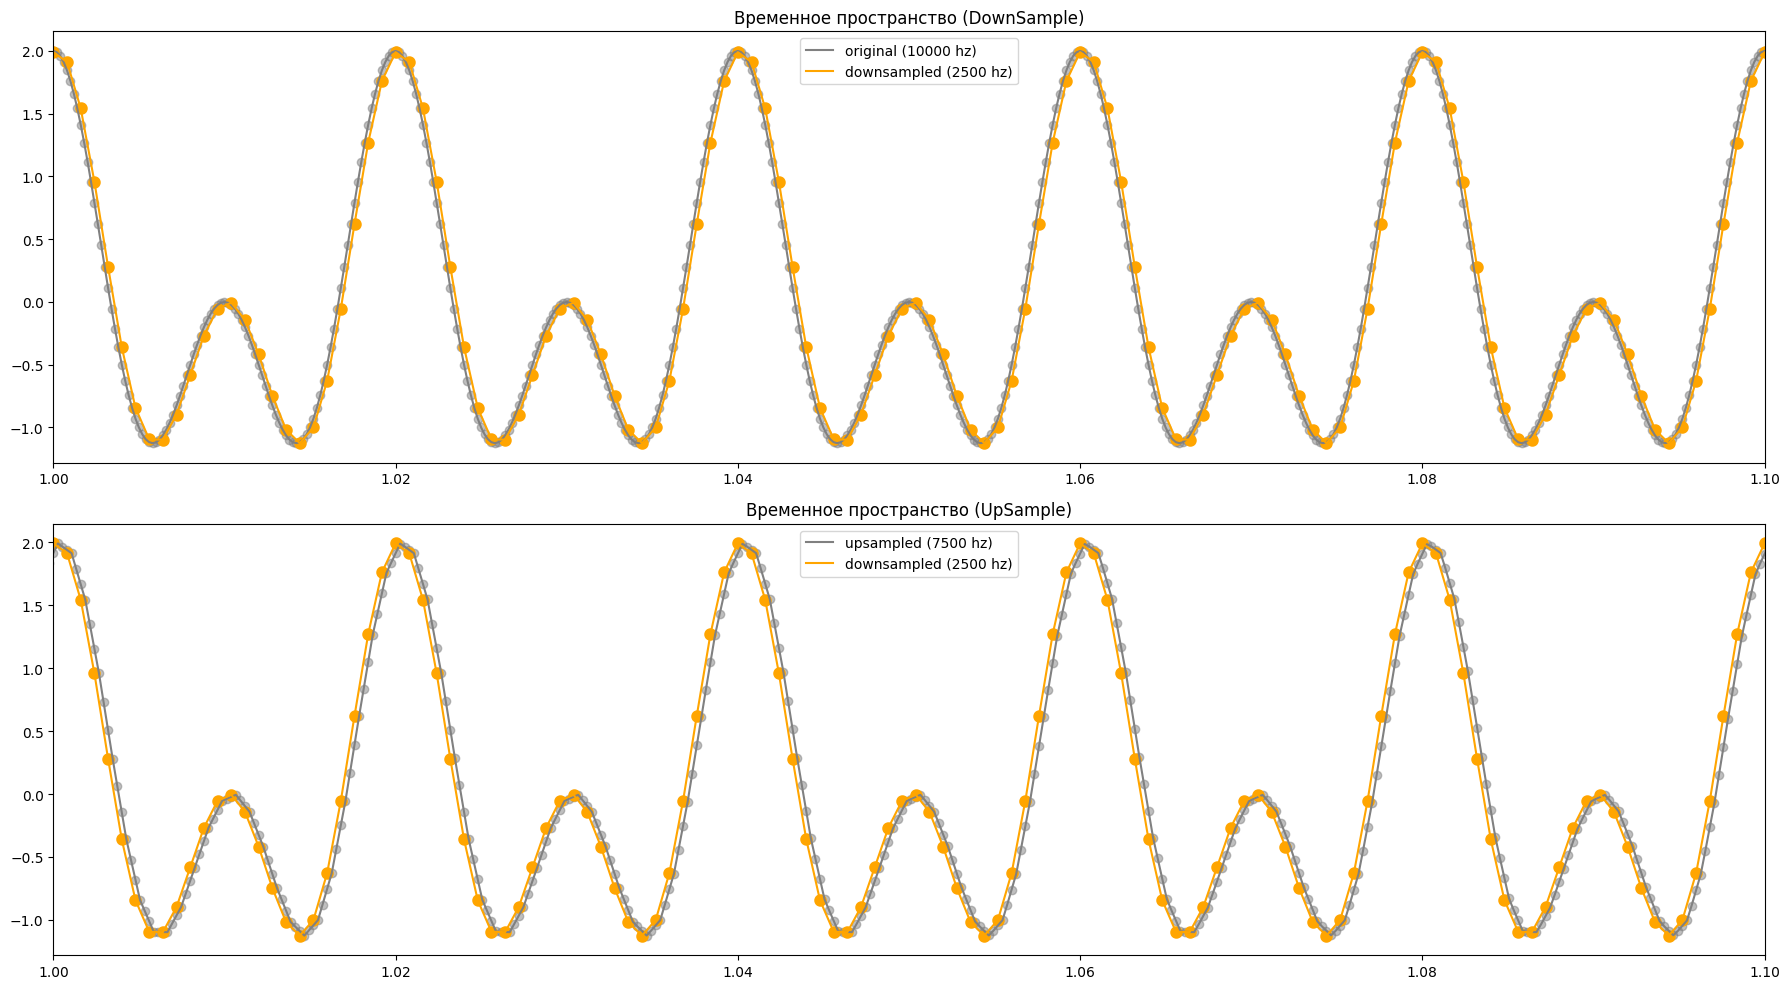

In [37]:
plt.figure(figsize=(18, 10))

plt.subplot(211)
plt.title("Временное пространство (DownSample)")
plt.plot(timeseries_t6, signal_t6, color='gray', label=f'original ({samplerate} hz)')
plt.scatter(timeseries_t6, signal_t6, color='gray', alpha=0.5)

plt.plot(downsampled_timeseries, downsampled_signal_t6, color='orange', label=f'downsampled ({downsampled_rate} hz)')
plt.scatter(downsampled_timeseries, downsampled_signal_t6, color='orange', lw=3)

plt.xlim([1, 1.1])
plt.legend()

plt.subplot(212)
plt.title("Временное пространство (UpSample)")
plt.plot(upsampled_timeseries, upsampled_signal_t6, color='grey', label=f'upsampled ({upsampled_rate} hz)')
plt.scatter(upsampled_timeseries, upsampled_signal_t6, color='grey', alpha=0.5)


plt.plot(downsampled_timeseries, downsampled_signal_t6, color='orange', label=f'downsampled ({downsampled_rate} hz)')
plt.scatter(downsampled_timeseries, downsampled_signal_t6, color='orange', lw=3)

plt.xlim([1, 1.1])
plt.legend()
plt.tight_layout()
plt.show()

## Задание 7

In [38]:
cos_50hzf = cosinus_signal_func(freq=50)

signal1_t6, timeseries1_t6 = calc_signal(cos_50hzf, t_end=0.1, samples=30)
signal2_t6, timeseries2_t6 = calc_signal(cos_50hzf, t_end=0.1, samples=50)
signal3_t6, timeseries3_t6 = calc_signal(cos_50hzf, t_end=0.1, samples=100)

signal1_t6_up = upsample_signal(signal1_t6, 30, 50)
timeseries1_t6_up = np.linspace(0, 0.1, len(signal1_t6_up))

signal3_t6_down = nyquist_downsample(signal3_t6, 100, 50)
timeseries3_t6_down = np.linspace(0, 0.1, len(signal3_t6_down))

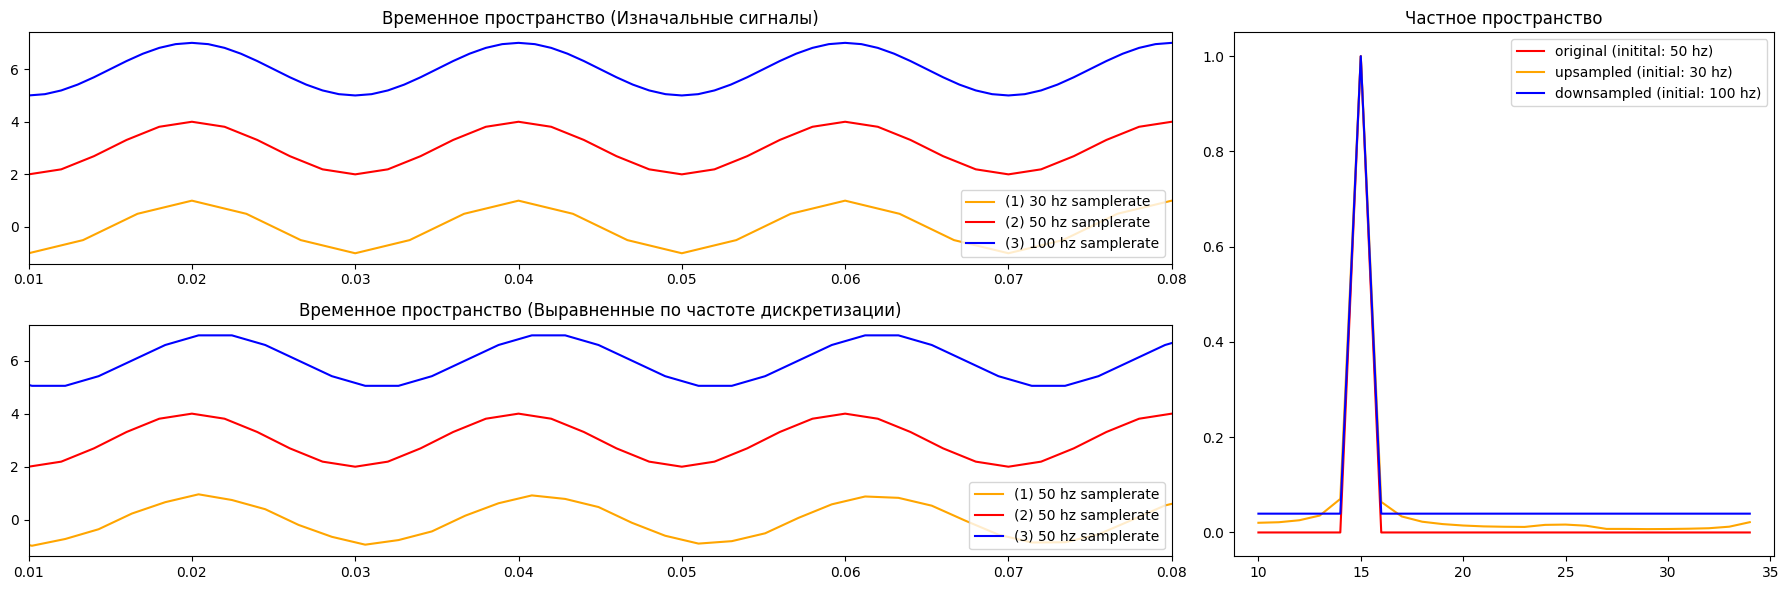

In [39]:
fig, ax = plt.subplot_mosaic(
    [["tl", "tl", "br"],
     ["bl", "bl", "br"]],
     figsize=(18,6)
)

ax['tl'].set_title("Временное пространство (Изначальные сигналы)")
ax['tl'].plot(timeseries1_t6, signal1_t6, color='orange', label='(1) 30 hz samplerate')
ax['tl'].plot(timeseries2_t6, signal2_t6 +3, color='red', label='(2) 50 hz samplerate')
ax['tl'].plot(timeseries3_t6, signal3_t6 +6, color='blue', label='(3) 100 hz samplerate')
ax['tl'].legend(loc="lower right")
ax['tl'].set_xlim([0.01,0.08])


ax['bl'].set_title("Временное пространство (Выравненные по частоте дискретизации)")
ax['bl'].plot(timeseries1_t6_up, signal1_t6_up, color='orange', label='(1) 50 hz samplerate')
ax['bl'].plot(timeseries2_t6, signal2_t6 +3, color='red', label='(2) 50 hz samplerate')
ax['bl'].plot(timeseries3_t6_down, signal3_t6_down+6, color='blue', label='(3) 50 hz samplerate')
ax['bl'].legend(loc="lower right")
ax['bl'].set_xlim([0.01,0.08])

ax['br'].set_title("Частное пространство")
s_2_spec_ch = get_positive_spectrum(signal2_t6, samplerate=50)
ax['br'].plot(s_2_spec_ch[0]+10, s_2_spec_ch[1], color='red', label="original (initital: 50 hz)")

s_1_spec_ch = get_positive_spectrum(signal1_t6_up, samplerate=50)
ax['br'].plot(s_1_spec_ch[0]+10, s_1_spec_ch[1], color='orange', label='upsampled (initial: 30 hz)')

s_3_spec_ch = get_positive_spectrum(signal3_t6_down, samplerate=50)
ax['br'].plot(s_3_spec_ch[0]+10, s_3_spec_ch[1], color='blue', label='downsampled (initial: 100 hz)')

ax['br'].legend()

plt.tight_layout()
plt.show()